# Project : Deep Learning Classification - Disaster Tweets

The goal of the project is to predict whether or not a tweet is about a disaster

In [1]:
!pip install -U kaleido # run this cell if you run this notebook in Google Colab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import re
import math
from sklearn.model_selection import train_test_split
from spacy.symbols import ORTH
from spacy.lang.en.stop_words import STOP_WORDS
pio.renderers.default = 'png' # Comment/Delete this line if you want to show the figures in interactive format
pd.options.display.max_colwidth = 200
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Install and import tensorflow-addons to use f1-score as an evaluation metric in training

!pip install tensorflow-addons -q
import tensorflow_addons as tfa

_Note : All the work here is done on the 'train.csv' dataset. The test dataset is only use for checking the results._

In [4]:
df = pd.read_csv('train.csv')
df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


## 1. Preliminary EDA and features selection

In [5]:
# Checking the target distribution
target_distr = (df.value_counts('target')/len(df)*100).sort_index(ascending = False)
target_distr

target
1    42.965979
0    57.034021
dtype: float64

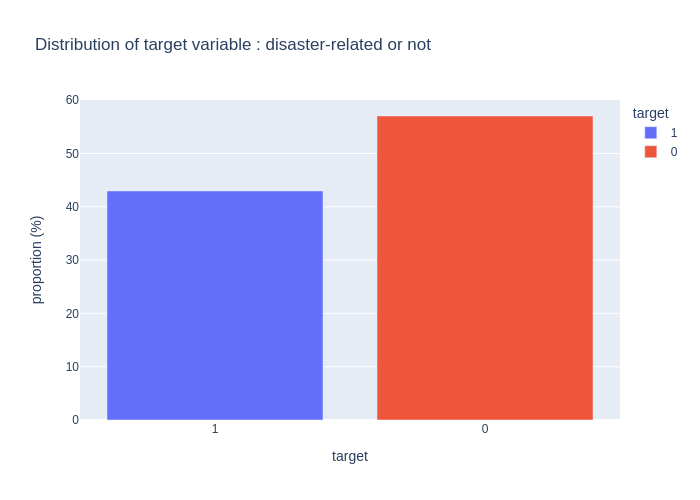

In [6]:
target_hist = px.bar(x = target_distr.index.astype(str), y = target_distr.values, color = target_distr.index.astype(str),
                     title = "Distribution of target variable : disaster-related or not",
                     labels = {
                         "x": "target",
                         "y": "proportion (%)",
                         "color" : "target"
                         }
                     )
target_hist.show()

=> The dataset seems lightly inbalanced in terms of target distribution.   
**Using the accuracy as the classification metric would still be a quite reasonable choice anyway (as the dataset is not too inbalanced) , but for information, we will also monitor our models' performances using the f1-score.**   

### 1.1 Influence of location

In [7]:
df_with_loc = df[~df['location'].isna()]

In [8]:
print(f"{round(len(df_with_loc)/len(df)*100)}% of observations have their location feature provided in the dataset.")

67% of observations have their location feature provided in the dataset.


Let's plot if there is a significant difference of distribution of the target between the tweets for which a keyword or localization information is missing : 

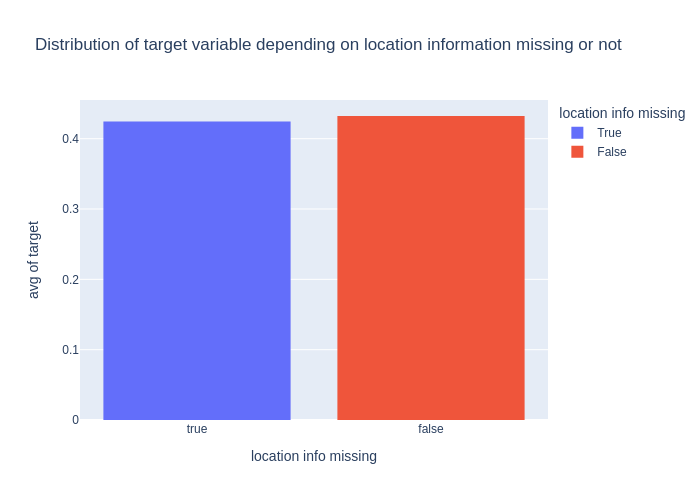

In [9]:
location_hist = px.histogram(df, x = df['location'].isna(), y = 'target', color = df['location'].isna(), histfunc = 'avg',
                             title = "Distribution of target variable depending on location information missing or not",
                             labels = {
                                 "x": "location info missing",
                                 "color" : "location info missing"
                                  })
location_hist.show()

=> The presence of the location information does not significantly affect the target distribution. Let's now check how many different values we have in the 'location' column : 

In [10]:
print(f"There are {df['location'].nunique()} different locations values in the dataset => each value is shared in average by less than {math.ceil(len(df_with_loc)/df['location'].nunique())} observations")

There are 3341 different locations values in the dataset => each value is shared in average by less than 2 observations


=> In average, each different location value is shared by less than 2 observations, which makes this information almost specific to each data point.   
**Hence, to prevent potential overfitting on the dataset, and considering the hypothesis that disasters may occur anywhere in the world, we choose to not consider the location information in that study.**

### 1.2. Influence of keyword 

In [11]:
print(df['keyword'].unique())

[nan 'ablaze' 'accident' 'aftershock' 'airplane%20accident' 'ambulance'
 'annihilated' 'annihilation' 'apocalypse' 'armageddon' 'army' 'arson'
 'arsonist' 'attack' 'attacked' 'avalanche' 'battle' 'bioterror'
 'bioterrorism' 'blaze' 'blazing' 'bleeding' 'blew%20up' 'blight'
 'blizzard' 'blood' 'bloody' 'blown%20up' 'body%20bag' 'body%20bagging'
 'body%20bags' 'bomb' 'bombed' 'bombing' 'bridge%20collapse'
 'buildings%20burning' 'buildings%20on%20fire' 'burned' 'burning'
 'burning%20buildings' 'bush%20fires' 'casualties' 'casualty'
 'catastrophe' 'catastrophic' 'chemical%20emergency' 'cliff%20fall'
 'collapse' 'collapsed' 'collide' 'collided' 'collision' 'crash' 'crashed'
 'crush' 'crushed' 'curfew' 'cyclone' 'damage' 'danger' 'dead' 'death'
 'deaths' 'debris' 'deluge' 'deluged' 'demolish' 'demolished' 'demolition'
 'derail' 'derailed' 'derailment' 'desolate' 'desolation' 'destroy'
 'destroyed' 'destruction' 'detonate' 'detonation' 'devastated'
 'devastation' 'disaster' 'displaced' 'droug

Many keywords in the dataset seem to be linked with the vocabulary of disasters.
Let's check the influence the keyword has in terms of target distribution : 

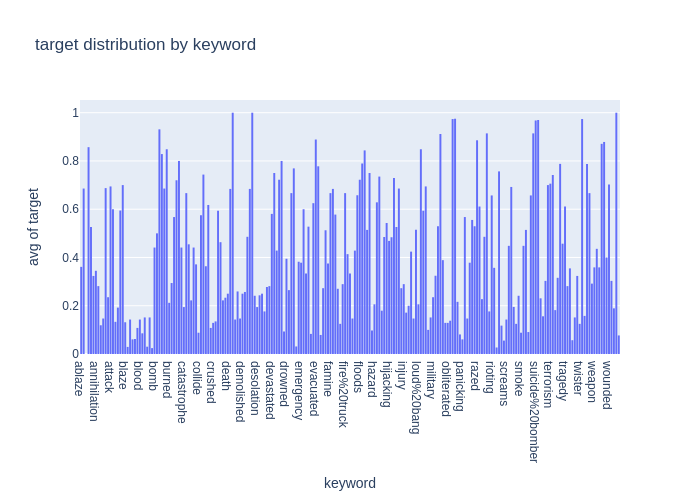

In [12]:
keyword_hist = px.histogram(df, x = 'keyword', y = 'target', histfunc = 'avg', 
                            title = "target distribution by keyword")
keyword_hist.show()

The keyword has apparently a real influence on the target, but let's check if this hypothesis is statistically reliable :

In [13]:
df_with_keyword = df[~df['keyword'].isna()]

In [14]:
print(f"{round(len(df_with_keyword)/len(df)*100)}% of observations have their keyword feature provided in the dataset.")

99% of observations have their keyword feature provided in the dataset.


In [15]:
print(f"There are {df['keyword'].nunique()} different keyword values in the dataset => each value is shared in average by less than "\
      f"{math.ceil(len(df_with_keyword)/df['keyword'].nunique())} observations "\
      f"({round(1/df['keyword'].nunique()*100,1)}%)")

There are 221 different keyword values in the dataset => each value is shared in average by less than 35 observations (0.5%)


- This time, contrarily to the location feature, the keyword feature has very few missing values.
- But each unique values still represents too few different observations in average (less than 1%) for this information to be statistically reliable without overfitting.
- In addition, we don't have the information on how this keyword is obtained.  

=> **so we decide to not use the keyword feature in our study.**

### 1.3. Features used for training

As we decided to not use in the training of our model : 
- the location feature
- the keyword feature

And as the id feature is an identifier, we also drop this feature. 

**=> This means that the only feature left is the text of the tweet, making our study a pure NLP subject.**  

In [16]:
df = df.drop(columns = ['id', 'location', 'keyword'])
df

,text,target
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,"13,000 people receive #wildfires evacuation orders in California",1
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1
...,...,...
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1


## 2. Language Preprocessing

For this text preprocessing, we will use some preprocessings operations in simple python / Pandas functions, and some using Spacy.

In [17]:
!python -m spacy download en_core_web_md -q

2022-10-03 15:02:27.817820: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
     |████████████████████████████████| 42.8 MB 2.4 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [18]:
import en_core_web_md
nlp = en_core_web_md.load()

def preprocess_text(dataframe):
  # Remove urls :
  dataframe['text_clean'] = dataframe['text'].apply(lambda x: re.sub("https?:\/\/[^ \n]+"," ", x))
  
  # Remove all non alphanumeric characters except whitespaces
  dataframe["text_clean"] = dataframe["text_clean"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch in [" ","@"])) 
    # we keep '@' to handle mentions specifically later
  
  #replacing all "@" twitter mentions by the token '<MENTION>' do differenciate mentions from the default OOV token
  dataframe["text_clean"] = dataframe["text_clean"].apply(lambda x: re.sub("^@[^ \n]+| @[^ \n]+"," <mention> ",x)) 
    # first part matching all '@' mentions at the beginning of a string
    # second part matching all '@' mentions following a whitespace 
  
  # remove double spaces and spaces at the beginning and end of strings
  dataframe["text_clean"] = dataframe["text_clean"].apply(lambda x: re.sub(" +"," ",x).lower().strip())
  
  # Adapt the nlp tokenizer to leave the "<mention>" special token as it is and not split it in 3 tokens "<", "mention" and ">" : 
  nlp.tokenizer.add_special_case(u'<mention>',[{ORTH : u'<mention>'}])

  # remove stop words and replace every word with their lemma
  df["text_clean"] = df["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) & (token.text not in STOP_WORDS)]))

In [19]:
preprocess_text(df)
df

,text,target,text_clean
0,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,deed reason earthquake allah forgive
1,Forest fire near La Ronge Sask. Canada,1,forest fire near la ronge sask canada
2,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1,resident ask shelter place notify officer evacuation shelter place order expect
3,"13,000 people receive #wildfires evacuation orders in California",1,13000 people receive wildfire evacuation order california
4,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,got send photo ruby alaska smoke wildfire pour school
...,...,...,...
7608,Two giant cranes holding a bridge collapse into nearby homes http://t.co/STfMbbZFB5,1,giant crane hold bridge collapse nearby home
7609,@aria_ahrary @TheTawniest The out of control wild fires in California even in the Northern part of the state. Very troubling.,1,<mention> <mention> control wild fire california northern state troubling
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ,1,m194 0104 utc5 km s volcano hawaii
7611,Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.,1,police investigate ebike collide car little portugal ebike rider suffer nonlife threaten injury


In [20]:
num_words = 5500
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = num_words, oov_token = '<OOV>', filters = '')
tokenizer.fit_on_texts(df.text_clean)
df["text_encoded"] = tokenizer.texts_to_sequences(df.text_clean)

df["len_text"] = df["text_encoded"].apply(lambda x: len(x))
df = df[df["len_text"]!=0]
print(tokenizer.word_index)

{'<OOV>': 1, '<mention>': 2, 'like': 3, 'fire': 4, 'm': 5, 'amp': 6, 's': 7, 'new': 8, 'people': 9, 'news': 10, 'video': 11, 'burn': 12, 'kill': 13, '2': 14, 'come': 15, 'crash': 16, 'bomb': 17, 'emergency': 18, 'disaster': 19, 'attack': 20, 'good': 21, 'body': 22, 'year': 23, 'look': 24, 'time': 25, 'police': 26, 'man': 27, 'day': 28, 'home': 29, 'know': 30, 'family': 31, 'flood': 32, 'building': 33, 'think': 34, 'love': 35, 'storm': 36, 'train': 37, 'california': 38, 'watch': 39, 'suicide': 40, 'want': 41, 'world': 42, 'collapse': 43, 'work': 44, 'scream': 45, 'life': 46, 'bag': 47, 'car': 48, 'death': 49, 'rt': 50, '3': 51, 'cause': 52, 'need': 53, 'nuclear': 54, 'wreck': 55, 'drown': 56, 'war': 57, 'accident': 58, 'destroy': 59, 'dead': 60, 'today': 61, 'fear': 62, 'help': 63, 'weapon': 64, 'live': 65, 'hiroshima': 66, 'way': 67, 'wound': 68, 'feel': 69, 'wildfire': 70, 'plan': 71, 'find': 72, 'u': 73, 'pm': 74, 'survive': 75, 'bad': 76, 'big': 77, 'blow': 78, 'injury': 79, 'rescue

In [21]:
print("Displaying the vocabulary kept and the vocabulary thrown to verify the good choice of num_words")

print("whole vocabulary size : ", len(tokenizer.index_word))
print("vocabulary kept : ", [(k,v) for k, v in tokenizer.word_index.items()][:num_words])

Displaying the vocabulary kept and the vocabulary thrown to verify the good choice of num_words
whole vocabulary size :  13644
vocabulary kept :  [('<OOV>', 1), ('<mention>', 2), ('like', 3), ('fire', 4), ('m', 5), ('amp', 6), ('s', 7), ('new', 8), ('people', 9), ('news', 10), ('video', 11), ('burn', 12), ('kill', 13), ('2', 14), ('come', 15), ('crash', 16), ('bomb', 17), ('emergency', 18), ('disaster', 19), ('attack', 20), ('good', 21), ('body', 22), ('year', 23), ('look', 24), ('time', 25), ('police', 26), ('man', 27), ('day', 28), ('home', 29), ('know', 30), ('family', 31), ('flood', 32), ('building', 33), ('think', 34), ('love', 35), ('storm', 36), ('train', 37), ('california', 38), ('watch', 39), ('suicide', 40), ('want', 41), ('world', 42), ('collapse', 43), ('work', 44), ('scream', 45), ('life', 46), ('bag', 47), ('car', 48), ('death', 49), ('rt', 50), ('3', 51), ('cause', 52), ('need', 53), ('nuclear', 54), ('wreck', 55), ('drown', 56), ('war', 57), ('accident', 58), ('destroy'

In [22]:
print("vocabulary thrown : ", [(k,v) for k, v in tokenizer.word_index.items()][num_words:])

vocabulary thrown :  [('g90', 5501), ('statistically', 5502), ('colombia', 5503), ('wher', 5504), ('rodkiai', 5505), ('emsneû', 5506), ('aberystwythshrewsbury', 5507), ('shrew', 5508), ('nanotech', 5509), ('clot', 5510), ('mosh', 5511), ('justsaying', 5512), ('randomthought', 5513), ('dna', 5514), ('nissan', 5515), ('ems1', 5516), ('emts', 5517), ('ûminimum', 5518), ('wageûª', 5519), ('paramedics', 5520), ('ûï@leoblakecarter', 5521), ('hatzolah', 5522), ('lesotho', 5523), ('standardised', 5524), ('clinical', 5525), ('jwalk', 5526), ('freiza', 5527), ('petebest', 5528), ('dessicate', 5529), ('kneel', 5530), ('heysundown', 5531), ('celticindeed', 5532), ('mizzou', 5533), ('muschamps', 5534), ('bama', 5535), ('mba', 5536), ('careen', 5537), ('eovm', 5538), ('entirely', 5539), ('suregod', 5540), ('wnuke', 5541), ('armenian', 5542), ('minus', 5543), ('toenail', 5544), ('1960', 5545), ('oryx', 5546), ('symbol', 5547), ('peninsula', 5548), ('bucs', 5549), ('philip', 5550), ('sophistication', 

In [23]:
df.sample(50)[['text','text_clean','text_encoded','target']]

,text,text_clean,text_encoded,target
1266,What progress we are making. In the Middle Ages they would have burned me. Now they are content with burning my books. -Sigmund Freud,progress middle age burn content burn book sigmund freud,"[1823, 821, 1446, 12, 171, 12, 362, 1, 1]",0
2251,Businesses are deluged with invokces. Make yours stand out with colour or shape.and it's likely to rise to the top of the pay' pile.,business deluge invokce stand colour shapeand likely rise pay pile,"[285, 138, 1, 469, 1212, 1, 824, 277, 516, 753]",0
1572,alex is making me watch 107 facts about minions i want to fall off a cliff help,alex watch 107 fact minion want fall cliff help,"[3117, 39, 1, 852, 3118, 41, 84, 317, 63]",0
7468,@Squeaver just hangin out in star buck watchin my boy wreck this septic tank,<mention> hangin star buck watchin boy wreck septic tank,"[2, 1, 435, 5167, 1, 191, 55, 1, 1287]",0
5217,OH. #TeamHennessy #NJ Obliteration @tprimo24 ROUND 1 Happy Birthday @djeddygnj Colombian FestivalÛ_ https://t.co/mRv54fiDfn,oh teamhennessy nj obliteration <mention> round 1 happy birthday <mention> colombian festivalû,"[351, 1, 4826, 443, 2, 1183, 126, 573, 1103, 2, 1, 1]",0
6593,Remembrance http://t.co/ii4EwE1QIr #Hiroshima http://t.co/H3vUsqzyQo,remembrance hiroshima,"[1, 66]",1
3113,got electrocuted last night at work for the first time in my life.... shit was weird ????,got electrocute night work time life shit weird,"[256, 145, 186, 44, 25, 46, 161, 1255]",0
2375,@TemecaFreeman GM! I pray any attack of the enemy 2 derail ur destiny is blocked by the Lord &amp; that He floods ur life w/heavenly Blessings,<mention> gm pray attack enemy 2 derail ur destiny block lord amp flood ur life wheavenly blessing,"[2, 1293, 726, 20, 1437, 14, 99, 440, 1878, 428, 632, 6, 32, 440, 46, 1879, 1658]",1
4455,@hannahkauthor Read: American lives first | The Chronicle #FreeAmirNow #FreeALLFour #Hostages held by #Iran #IranDeal http://t.co/gWnLHNeKu9,<mention> read american live chronicle freeamirnow freeallfour hostage hold iran irandeal,"[2, 118, 518, 65, 3818, 1, 1, 107, 314, 328, 1422]",1
4530,And you wonder why he's injured every year https://t.co/XYiwR9JETl,wonder s injure year,"[593, 7, 183, 23]",0


In [24]:
# Padding of sequences to have the same length for all vectorized observations
padded_array = tf.keras.preprocessing.sequence.pad_sequences(df['text_encoded'], padding="post")
padded_array

array([[3593,  411,  172, ...,    0,    0,    0],
       [ 119,    4,  165, ...,    0,    0,    0],
       [1378,  444, 1701, ...,    0,    0,    0],
       ...,
       [2657, 3588, 5293, ...,    0,    0,    0],
       [  26,  736, 2541, ...,    0,    0,    0],
       [ 102,   29,  358, ...,    0,    0,    0]], dtype=int32)

In [25]:
# Splitting in a train and validation set with sklearn
train, val, y_train, y_val = train_test_split(padded_array, df['target'], random_state = 0, stratify = df['target'], test_size = 0.3) # split on the dataframes to keep track of the index
print(train.shape)
print(val.shape)

(5328, 25)
(2284, 25)


In [26]:
# Creation of tensorflow tensors from train and validation sets
train_ds = tf.data.Dataset.from_tensor_slices((train, y_train))
val_ds = tf.data.Dataset.from_tensor_slices((val, y_val))

# Shuffling and batching
train_ds = train_ds.shuffle(len(train_ds)).batch(128)
val_ds = val_ds.shuffle(len(val_ds)).batch(128)

## 3. Model training

As we are dealing with phrases, we will have to deal with the sequential aspect of the data. **We'll hence use recurrent neural networks in our model architecture.**

The efficiency of some recurrent deep learning model architectures will depend on the numbers of tokens to process in one single observation. With this in mind, let's check the distribution of the texts' number of words before choosing an architecture : 

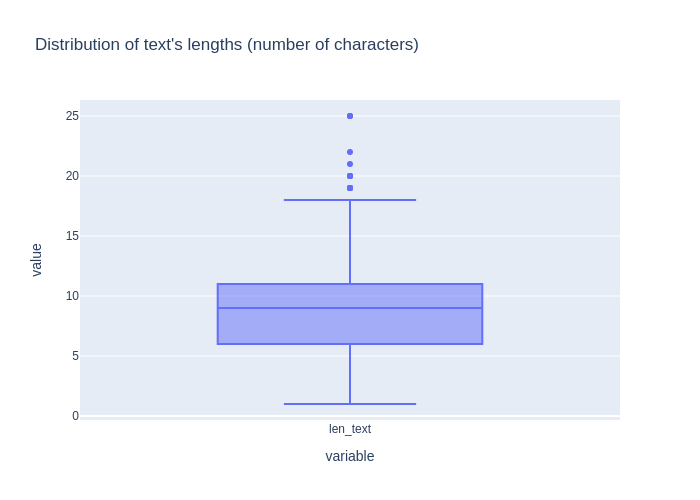

In [27]:
px.box(df['len_text'], title = "Distribution of text's lengths (number of characters)")

=> In average, each tweet is less than 10 words after preprocessing, and their length can go up to 25 words in rare cases. As most of theses number of words are not too high, **we will test a simpleRNN architecture as well as the more long-length-adapted architectures (GRUs / LSTMs) and keep the architecture which shows the best performance.** 

### 3.1. SimpleRNN architecture

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 32)            176000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 16)                784       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 176,801
Trainable params: 176,801
Non-trainable params: 0
_________________________________________________________________


None

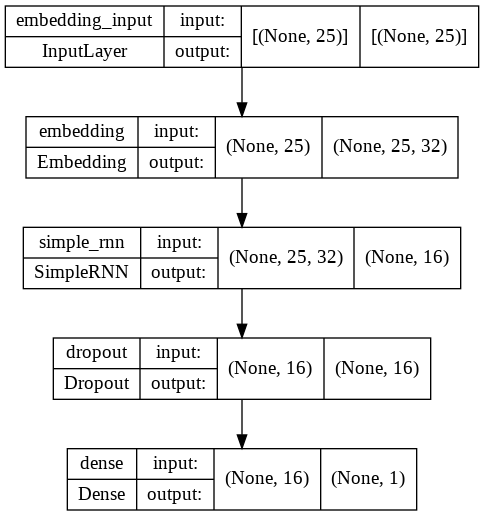

In [28]:
embedding_dim= 32 # the dimensionality of the representation space
#vocab_size = len(tokenizer.word_index) + 1
vocab_size = num_words 

model_sRNN = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding", input_length = (train.shape[-1])),
  tf.keras.layers.SimpleRNN(units=16, return_sequences=False), # returns the last output
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation="sigmoid") # the prediction layer
])

display(model_sRNN.summary())
tf.keras.utils.plot_model(model_sRNN, show_shapes = True)

In [29]:
model_sRNN.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',tfa.metrics.F1Score(num_classes = 1, average = 'micro', threshold = 0.5)])

In [30]:
model_sRNN.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20)

Epoch 1/20
42/42 [==============================] - 3s 29ms/step - loss: 0.6863 - accuracy: 0.5582 - f1_score: 0.2602 - val_loss: 0.6796 - val_accuracy: 0.5784 - val_f1_score: 0.0731
Epoch 2/20
42/42 [==============================] - 1s 17ms/step - loss: 0.6768 - accuracy: 0.5783 - f1_score: 0.1790 - val_loss: 0.6742 - val_accuracy: 0.5919 - val_f1_score: 0.1290
Epoch 3/20
42/42 [==============================] - 1s 14ms/step - loss: 0.6674 - accuracy: 0.6164 - f1_score: 0.3071 - val_loss: 0.6638 - val_accuracy: 0.6283 - val_f1_score: 0.3012
Epoch 4/20
42/42 [==============================] - 1s 15ms/step - loss: 0.6424 - accuracy: 0.6762 - f1_score: 0.4818 - val_loss: 0.6332 - val_accuracy: 0.7045 - val_f1_score: 0.5820
Epoch 5/20
42/42 [==============================] - 1s 17ms/step - loss: 0.5940 - accuracy: 0.7509 - f1_score: 0.6640 - val_loss: 0.5839 - val_accuracy: 0.7430 - val_f1_score: 0.6896
Epoch 6/20
42/42 [==============================] - 1s 15ms/step - loss: 0.5363 - acc

In [31]:
history = model_sRNN.history.history
history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])

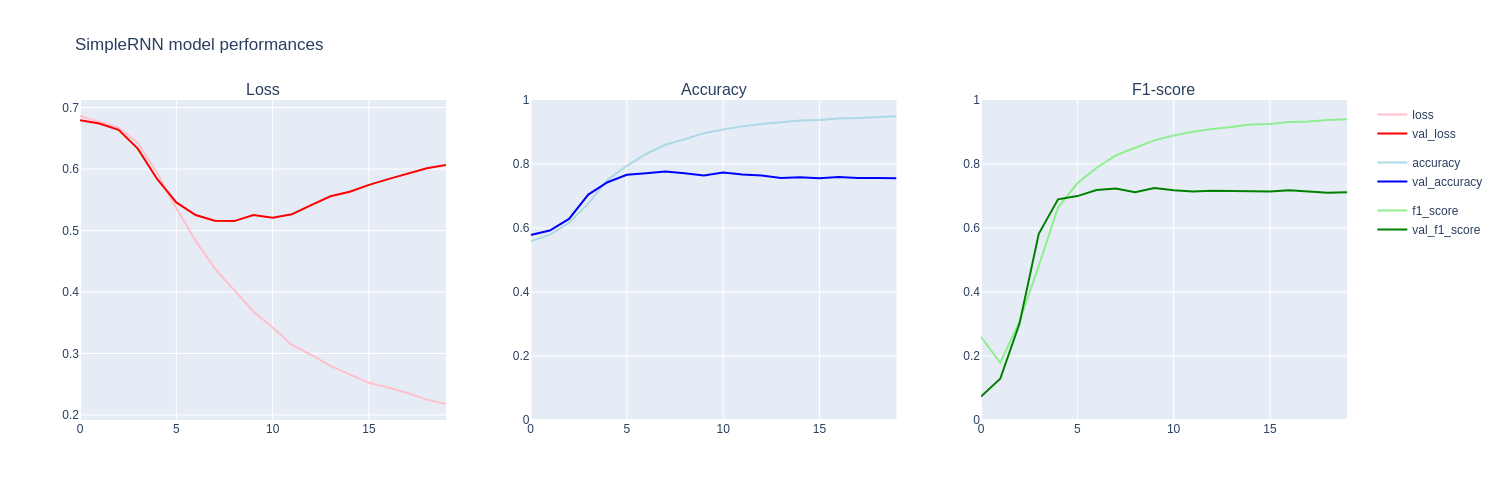

In [32]:
fig = make_subplots(rows = 1, cols = 3, subplot_titles = ("Loss", "Accuracy", "F1-score"))

fig.add_trace(go.Scatter(y=history["loss"],
                    mode='lines',
                    name='loss',
                    legendgroup = "Loss",
                    line_color = "pink"),
              row = 1,
              col = 1)
fig.add_trace(go.Scatter(y=history["val_loss"],
                    mode='lines',
                    name='val_loss',
                    legendgroup = "Loss",
                    line_color = "red"),
              row = 1,
              col = 1)

fig.add_trace(go.Scatter(y=history["accuracy"],
                    mode='lines',
                    name='accuracy',
                    legendgroup = "Accuracy",
                    line_color = "lightblue"),
              row = 1,
              col = 2)
fig.add_trace(go.Scatter(y=history["val_accuracy"],
                    mode='lines',
                    name='val_accuracy',
                    legendgroup = "Accuracy",
                    line_color = "blue"),
              row = 1,
              col = 2)

fig.add_trace(go.Scatter(y=history["f1_score"],
                    mode='lines',
                    name='f1_score',
                    legendgroup = "F1-score",
                    line_color = "lightgreen"),
              row = 1,
              col = 3)
fig.add_trace(go.Scatter(y=history["val_f1_score"],
                    mode='lines',
                    name='val_f1_score',
                    legendgroup = "F1-score",
                    line_color = "green"),
              row = 1,
              col = 3)

fig.update_layout(title_text = "SimpleRNN model performances", width = 1500,
                  yaxis2_range= [0, 1], yaxis3_range = [0, 1])
fig.show()

### 3.2. GRUs architecture

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 32)            176000    
                                                                 
 gru (GRU)                   (None, 16)                2400      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 178,417
Trainable params: 178,417
Non-trainable params: 0
_________________________________________________________________


None

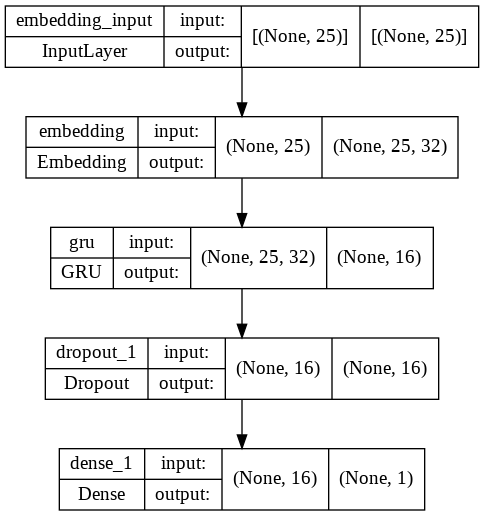

In [33]:
embedding_dim= 32 # the dimensionality of the representation space
#vocab_size = len(tokenizer.word_index) + 1
vocab_size = num_words 

model_GRU = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding", input_length = (train.shape[-1])),
  tf.keras.layers.GRU(units=16, return_sequences=False), # returns the last output
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation="sigmoid") # the prediction layer
])

display(model_GRU.summary())
tf.keras.utils.plot_model(model_GRU, show_shapes = True)

In [34]:
model_GRU.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',tfa.metrics.F1Score(num_classes = 1, average = 'micro', threshold = 0.5)])

In [35]:
model_GRU.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20)

Epoch 1/20
42/42 [==============================] - 5s 41ms/step - loss: 0.6912 - accuracy: 0.5614 - f1_score: 0.1380 - val_loss: 0.6895 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 2/20
42/42 [==============================] - 1s 26ms/step - loss: 0.6884 - accuracy: 0.5702 - f1_score: 8.7260e-04 - val_loss: 0.6872 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 3/20
42/42 [==============================] - 1s 24ms/step - loss: 0.6866 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6856 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 4/20
42/42 [==============================] - 1s 23ms/step - loss: 0.6851 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6846 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 5/20
42/42 [==============================] - 1s 24ms/step - loss: 0.6846 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6839 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 6/20
42/42 [==============================]

In [36]:
history = model_GRU.history.history
history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])

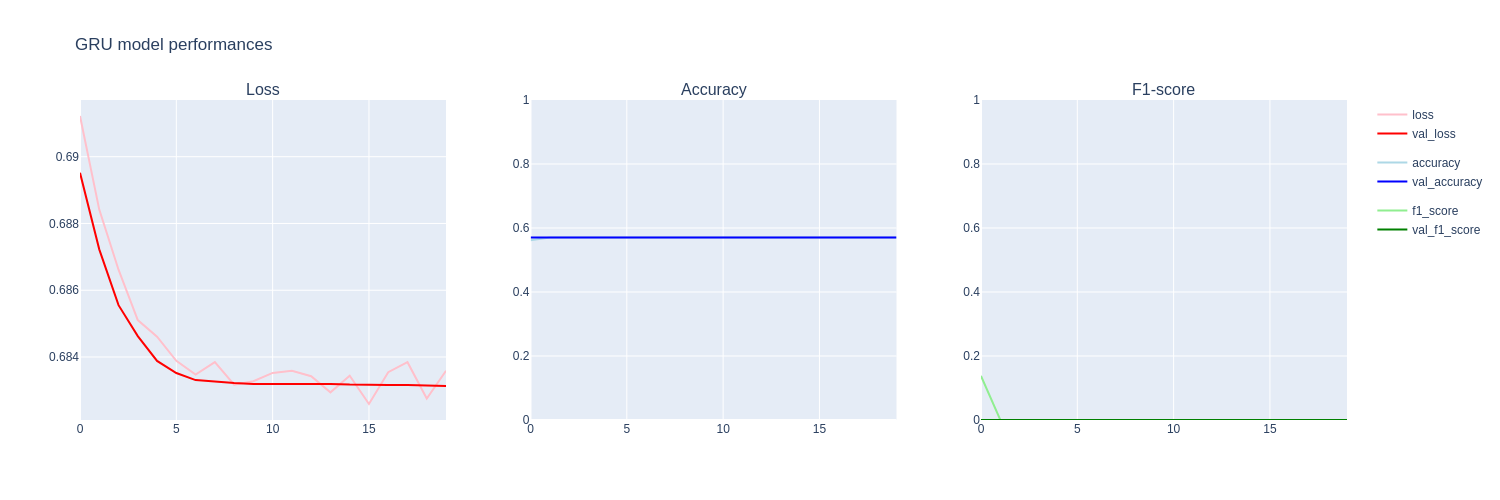

In [37]:
fig = make_subplots(rows = 1, cols = 3, subplot_titles = ("Loss", "Accuracy", "F1-score"))

fig.add_trace(go.Scatter(y=history["loss"],
                    mode='lines',
                    name='loss',
                    legendgroup = "Loss",
                    line_color = "pink"),
              row = 1,
              col = 1)
fig.add_trace(go.Scatter(y=history["val_loss"],
                    mode='lines',
                    name='val_loss',
                    legendgroup = "Loss",
                    line_color = "red"),
              row = 1,
              col = 1)

fig.add_trace(go.Scatter(y=history["accuracy"],
                    mode='lines',
                    name='accuracy',
                    legendgroup = "Accuracy",
                    line_color = "lightblue"),
              row = 1,
              col = 2)
fig.add_trace(go.Scatter(y=history["val_accuracy"],
                    mode='lines',
                    name='val_accuracy',
                    legendgroup = "Accuracy",
                    line_color = "blue"),
              row = 1,
              col = 2)

fig.add_trace(go.Scatter(y=history["f1_score"],
                    mode='lines',
                    name='f1_score',
                    legendgroup = "F1-score",
                    line_color = "lightgreen"),
              row = 1,
              col = 3)
fig.add_trace(go.Scatter(y=history["val_f1_score"],
                    mode='lines',
                    name='val_f1_score',
                    legendgroup = "F1-score",
                    line_color = "green"),
              row = 1,
              col = 3)

fig.update_layout(title_text = "GRU model performances", width = 1500,
                  yaxis2_range= [0, 1], yaxis3_range = [0, 1])
fig.show()

### 3.3. LSTMs architecture

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 32)            176000    
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 179,153
Trainable params: 179,153
Non-trainable params: 0
_________________________________________________________________


None

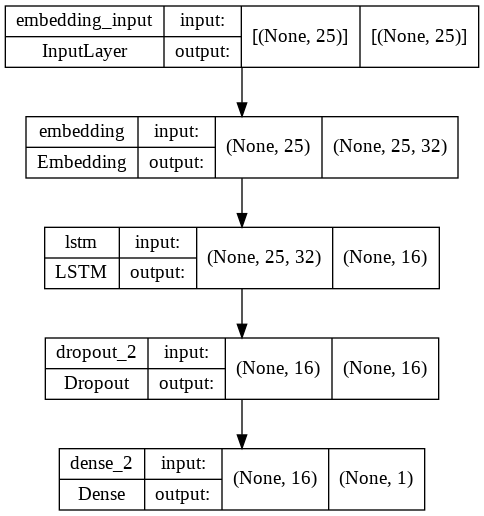

In [38]:
embedding_dim= 32 # the dimensionality of the representation space
#vocab_size = len(tokenizer.word_index) + 1
vocab_size = num_words 

model_LSTM = tf.keras.models.Sequential([
  tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding", input_length = (train.shape[-1])),
  tf.keras.layers.LSTM(units=16, return_sequences=False), # returns the last output
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation="sigmoid") # the prediction layer
])

display(model_LSTM.summary())
tf.keras.utils.plot_model(model_LSTM, show_shapes = True)

In [39]:
model_LSTM.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',tfa.metrics.F1Score(num_classes = 1, average = 'micro', threshold = 0.5)])

In [40]:
model_LSTM.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20)

Epoch 1/20
42/42 [==============================] - 5s 46ms/step - loss: 0.6923 - accuracy: 0.5383 - f1_score: 0.2545 - val_loss: 0.6906 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 2/20
42/42 [==============================] - 1s 23ms/step - loss: 0.6895 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6883 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 3/20
42/42 [==============================] - 1s 22ms/step - loss: 0.6873 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6860 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 4/20
42/42 [==============================] - 1s 23ms/step - loss: 0.6850 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6842 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 5/20
42/42 [==============================] - 1s 25ms/step - loss: 0.6838 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6825 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 6/20
42/42 [==============================]

In [41]:
history = model_LSTM.history.history
history.keys()

dict_keys(['loss', 'accuracy', 'f1_score', 'val_loss', 'val_accuracy', 'val_f1_score'])

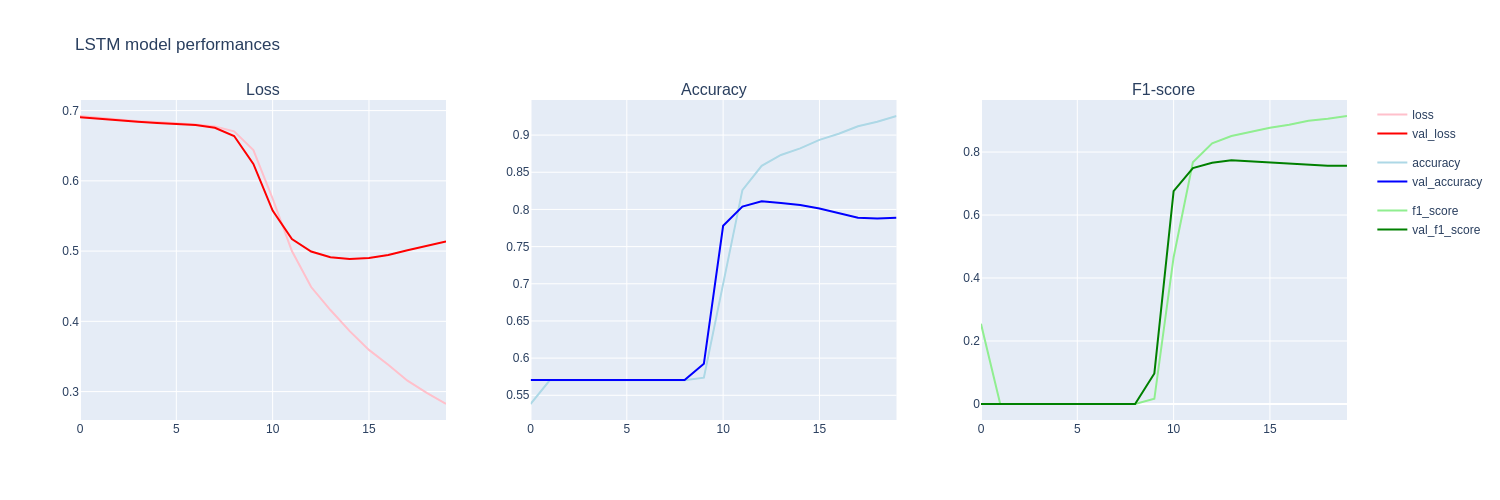

In [42]:
fig = make_subplots(rows = 1, cols = 3, subplot_titles = ("Loss", "Accuracy", "F1-score"))

fig.add_trace(go.Scatter(y=history["loss"],
                    mode='lines',
                    name='loss',
                    legendgroup = "Loss",
                    line_color = "pink"),
              row = 1,
              col = 1)
fig.add_trace(go.Scatter(y=history["val_loss"],
                    mode='lines',
                    name='val_loss',
                    legendgroup = "Loss",
                    line_color = "red"),
              row = 1,
              col = 1)

fig.add_trace(go.Scatter(y=history["accuracy"],
                    mode='lines',
                    name='accuracy',
                    legendgroup = "Accuracy",
                    line_color = "lightblue"),
              row = 1,
              col = 2)
fig.add_trace(go.Scatter(y=history["val_accuracy"],
                    mode='lines',
                    name='val_accuracy',
                    legendgroup = "Accuracy",
                    line_color = "blue"),
              row = 1,
              col = 2)

fig.add_trace(go.Scatter(y=history["f1_score"],
                    mode='lines',
                    name='f1_score',
                    legendgroup = "F1-score",
                    line_color = "lightgreen"),
              row = 1,
              col = 3)
fig.add_trace(go.Scatter(y=history["val_f1_score"],
                    mode='lines',
                    name='val_f1_score',
                    legendgroup = "F1-score",
                    line_color = "green"),
              row = 1,
              col = 3)

fig.update_layout(title_text = "LSTM model performances", width = 1500)
fig.show()

### 3.4. Model choice

We see that of the three recurrent model architectures we tried, the LSTM one performs better, and starts overfitting after epoch 12

**=> We'll choose to use the LSTM architecture trained on 12 epochs.**



In [43]:
# Starting over the training of the choosed model on less epochs
model = tf.keras.models.clone_model(model_LSTM)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy',tfa.metrics.F1Score(num_classes = 1, average = 'micro', threshold = 0.5)])
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=12)

Epoch 1/12
42/42 [==============================] - 4s 40ms/step - loss: 0.6915 - accuracy: 0.5531 - f1_score: 0.2626 - val_loss: 0.6890 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 2/12
42/42 [==============================] - 1s 29ms/step - loss: 0.6874 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6858 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 3/12
42/42 [==============================] - 1s 25ms/step - loss: 0.6843 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6833 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 4/12
42/42 [==============================] - 1s 26ms/step - loss: 0.6822 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6814 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 5/12
42/42 [==============================] - 1s 27ms/step - loss: 0.6805 - accuracy: 0.5702 - f1_score: 0.0000e+00 - val_loss: 0.6790 - val_accuracy: 0.5705 - val_f1_score: 0.0000e+00
Epoch 6/12
42/42 [==============================]

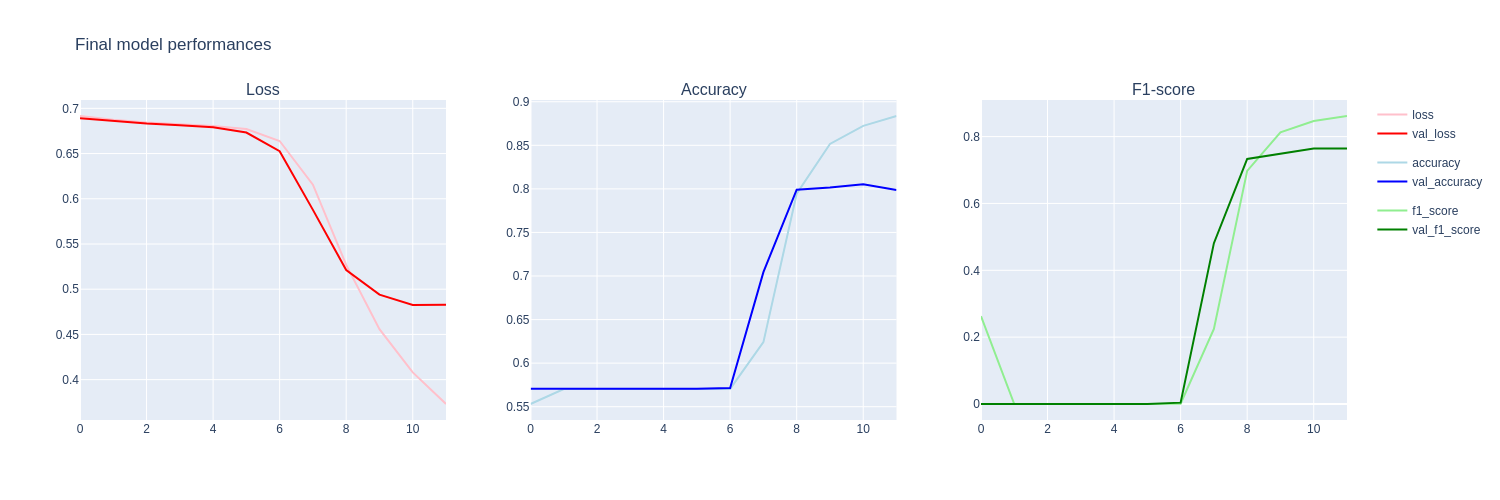

In [44]:
history = model.history.history

fig = make_subplots(rows = 1, cols = 3, subplot_titles = ("Loss", "Accuracy", "F1-score"))

fig.add_trace(go.Scatter(y=history["loss"],
                    mode='lines',
                    name='loss',
                    legendgroup = "Loss",
                    line_color = "pink"),
              row = 1,
              col = 1)
fig.add_trace(go.Scatter(y=history["val_loss"],
                    mode='lines',
                    name='val_loss',
                    legendgroup = "Loss",
                    line_color = "red"),
              row = 1,
              col = 1)

fig.add_trace(go.Scatter(y=history["accuracy"],
                    mode='lines',
                    name='accuracy',
                    legendgroup = "Accuracy",
                    line_color = "lightblue"),
              row = 1,
              col = 2)
fig.add_trace(go.Scatter(y=history["val_accuracy"],
                    mode='lines',
                    name='val_accuracy',
                    legendgroup = "Accuracy",
                    line_color = "blue"),
              row = 1,
              col = 2)

fig.add_trace(go.Scatter(y=history["f1_score"],
                    mode='lines',
                    name='f1_score',
                    legendgroup = "F1-score",
                    line_color = "lightgreen"),
              row = 1,
              col = 3)
fig.add_trace(go.Scatter(y=history["val_f1_score"],
                    mode='lines',
                    name='val_f1_score',
                    legendgroup = "F1-score",
                    line_color = "green"),
              row = 1,
              col = 3)

fig.update_layout(title_text = "Final model performances", width = 1500)
fig.show()

## 4. Predictions inspection

In [45]:
# Creating an "empty" prediction column and filling it out for all observations
df['pred'] = 'no prediction'
df.loc[y_train.index,'pred'] = model(train)
df.loc[y_val.index,'pred'] = model(val)

# Creating a binary prediction column and comparing with the target
df['pred_binary'] = df['pred'].apply(lambda x : 1 if x > 0.5 else 0)
df['good_pred'] = (df['target'] == df['pred_binary'])

df.sample(20, random_state = 0)

,text,target,text_clean,text_encoded,len_text,pred,pred_binary,good_pred
311,@KatieKatCubs you already know how this shit goes. World Series or Armageddon.,0,<mention> know shit world series armageddon,"[2, 30, 161, 42, 857, 391]",6,0.085745,0,True
4971,Meltdown,0,meltdown,[401],1,0.086895,0,True
528,Secrets up avalanche: catechize inner self for the confidential communication as respects creating worth in len...,0,secret avalanche catechize inner self confidential communication respect create worth len,"[532, 520, 1, 1416, 607, 1, 2899, 1284, 652, 1110, 2900]",11,0.081364,0,True
6363,#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_,1,bestnaijamade 16yr old pkk suicide bomber detonate bomb bestnaijamade bestnaijamade bestnaijamade beû,"[549, 463, 132, 406, 40, 142, 129, 17, 549, 549, 549, 1929]",12,0.753218,1,True
801,Sexual Revolution:Blight For Women is out! http://t.co/T8Sv2ai7sW Stories via @ACeBabes @HealthWeekly1 @AmateurNester,0,sexual revolutionblight woman story <mention> <mention> <mention>,"[2044, 1, 116, 202, 2, 2, 2]",7,0.196578,0,True
3075,@i_electroCute your turn ??,0,<mention> turn,"[2, 259]",2,0.08912,0,True
1834,Army sources say 12 persons on board including a team of doctors die in helicopter crashed near Mansehra. weather seems to be cause of crash,1,army source 12 person board include team doctor die helicopter crash near mansehra weather cause crash,"[97, 1469, 494, 371, 933, 848, 478, 1857, 88, 473, 16, 165, 2145, 190, 52, 16]",16,0.726325,1,True
2273,Just us four can demolish this?? @Createdunique23 @Keren_Serpa @ArianaReed11 https://t.co/PCiNc8ytFH,0,demolish <mention> <mention> <mention>,"[139, 2, 2, 2]",4,0.109734,0,True
1235,Multiple Buildings On Fire In Downtown Hinton http://t.co/P6kdh0p0Sp http://t.co/WaetKGsZA9,1,multiple building fire downtown hinton,"[2092, 33, 4, 738, 3062]",5,0.742719,1,True
1327,#ika #tuning Soup #diet recipes | fat burning soup recipes: http://t.co/8r5vpAoo5z Fat Burning Soup Diet Recip http://t.co/JvcxB75DrJ,0,ika tuning soup diet recipe fat burn soup recipe fat burning soup diet recip,"[1, 4064, 2493, 2101, 2102, 1108, 12, 2493, 2102, 1108, 1317, 2493, 2101, 1]",14,0.101576,0,True


In [46]:
# Calculating metrics on validation set 
df_val = df.loc[y_val.index]
df_val_tp =  df_val[(df_val['good_pred'] == True) & (df_val['pred_binary'] == 1)]
df_val_tn =  df_val[(df_val['good_pred'] == True) & (df_val['pred_binary'] == 0)]
df_val_fp =  df_val[(df_val['good_pred'] == False) & (df_val['pred_binary'] == 1)]
df_val_fn =  df_val[(df_val['good_pred'] == False) & (df_val['pred_binary'] == 0)]
accuracy = (len(df_val_tp) + len(df_val_tn)) / len(df_val)
precision = len(df_val_tp) / (len(df_val_tp) + len(df_val_fp))
recall = len(df_val_tp) / (len(df_val_tp) + len(df_val_fn))
f1_score = 2 * recall * precision / (recall + precision)
print("Accuracy : ", round(accuracy, 2))
print("Precision : ", round(precision, 2))
print("Recall : ", round(recall, 2))
print("F1-score : ", round(f1_score, 2))

Accuracy :  0.8
Precision :  0.77
Recall :  0.76
F1-score :  0.76


In [59]:
# Analysing examples of false negative predictions in validation set, sorted by increasing prediction certainty
print("False Negatives :")
print()
display(df_val_fn[['text','text_clean', 'pred']].sample(20, random_state = 0).sort_values('pred', ascending = False))

False Negatives :



,text,text_clean,pred
3638,OSP concerned about mounting fatalities http://t.co/YmP0gInwza http://t.co/FYIOQvIOif,osp concern mount fatality,0.484322
7003,Tornadoes: El Nino may give Canada's twister season a boost #Toronto http://t.co/agyCutKBnN,tornado el nino canadas twister season boost toronto,0.45313
3457,Kai Forbath just demolished a weather station set up on a drill field with a missed field goal. Thing just exploded into metal bits.,kai forbath demolish weather station set drill field missed field goal thing explode metal bit,0.431063
3474,I liked a @YouTube video http://t.co/bGAJ2oAX1p Huge Building Explosion at 2500fps - The Slow Mo Guys,like <mention> video huge building explosion 2500fps slow mo guy,0.195305
1454,@reriellechan HE WAS THE LICH KING'S FIRST CASUALTY BLOCK ME BACK I HATE YOU! http://t.co/0Gidg9U45J,<mention> lich king casualty block hate,0.191979
2141,Deaths 7 http://t.co/xRJA0XpL40,death 7,0.160174
3035,Some of the aftershocks can be just as big as the initial earthquake.~ http://t.co/HKbPqdncBa,aftershock big initial earthquake,0.147888
1192,US wont upgrade its infrastructure? http://t.co/NGEHhG9YGa' it a bad situation and its going to get ugly very quickly #USA #sustainability,upgrade infrastructure bad situation ugly quickly usa sustainability,0.142808
7410,Let's not forget our wounded female veterans. http://t.co/rZ7fbr10xw,lets forget wound female veteran,0.130066
5035,@UrufuSanRagu a Mudslide?,<mention> mudslide,0.120223


In [56]:
# Analysing examples of false positive predictions in validation set, sorted by increasing prediction certainty
print("False Positives :")
print()
display(df_val_fp[['text','text_clean', 'pred']].sample(20, random_state = 0).sort_values('pred'))

False Positives :



,text,text_clean,pred
5142,A little filming inside a Nuclear Reactor at #Chernobyl @SonyProUSA @LumixUSA @DJIGlobal @ProfBrianCox @RT_America https://t.co/2GLjhvEAD9,little filming inside nuclear reactor chernobyl <mention> <mention> <mention> <mention> <mention>,0.507208
5678,Man Who Buried Dog Alive Thought No One Would Find Her But She Was Rescued Just In Time http://t.co/SahQ5UOAHW,man bury dog alive think find rescue time,0.512334
200,HAPPENING NOW - HATZOLAH EMS AMBULANCE RESPONDING WITH DUAL SIRENS ANDÛ_ https://t.co/SeK6MQ6NJF,happen hatzolah ems ambulance respond dual siren andû,0.525845
2635,What's happening? A destruction indeed http://t.co/tUX0YPwZuR,s happen destruction,0.531573
1992,@writebothfists It got pretty windy here too... But no damage.,<mention> pretty windy damage,0.53517
1525,Looking for a #Defendant #Catastrophic Injury Solicitor #jobs http://t.co/Gz27aUDyHa http://t.co/P4EKgC9sIG,look defendant catastrophic injury solicitor job,0.543577
6268,The Secrets Of The Storm Vortex The Lightning Catcher Book Û_ : http://t.co/OIyWrzL79Z .,secret storm vortex lightning catcher book û,0.608238
1079,When you get a bomb ass picture mail ????????,bomb ass picture mail,0.642833
4218,http://t.co/7AzE4IoGMe Risk Assessment and Optimization for Routing Hazardous Waste Collection #sustainable environmental,risk assessment optimization route hazardous waste collection sustainable environmental,0.661566
18,My car is so fast,car fast,0.668825


## 5. Submitting predictions for test set

In [50]:
test_df = pd.read_csv('test.csv')

# Same preprocessings as for the train dataset : 
preprocess_text(test_df)
test_df["text_encoded"] = tokenizer.texts_to_sequences(test_df.text_clean)
test = tf.keras.preprocessing.sequence.pad_sequences(test_df['text_encoded'], padding="post", maxlen = padded_array.shape[-1])

# Making predictions on test dataset :
test_df['pred'] = model(test)
test_df['pred_binary'] = test_df['pred'].apply(lambda x : 1 if x > 0.5 else 0)

test_df.sample(20, random_state = 0)

,id,keyword,location,text,text_clean,text_encoded,pred,pred_binary
2464,8229,riot,NYC,Matt Baume Digs Into the the Controversial Û÷StonewallÛª Trailer and Who the Real Heroes of the Riot Were: VIDEO http://t.co/HRoxD1qpua #gay,matt baume digs into the the controversial ûstonewallûª trailer and who the real heroes of the riot were video gay,"[1, 1, 1, 1, 1, 1, 1, 1, 1766, 1, 1, 1, 302, 1, 1, 1, 160, 1, 11, 1038]",0.156634,0
1515,5045,eyewitness,NaN,Dutch crane collapses demolishes houses: Dramatic eyewitness video captures the moment a Dutch crane hoisting... http://t.co/8PpZNGYAqE,dutch crane collapses demolishes houses dramatic eyewitness video captures the moment a dutch crane hoisting,"[2020, 936, 1, 1, 1, 1911, 424, 11, 1, 1, 551, 1, 2020, 936, 1]",0.641400,1
2756,9168,suicide%20bomber,"Dubai, United Arab Emirates",More details: Bomber kills at least 13 at #Saudi mosque in Asir - including 10+ members of 'special emergency forces' http://t.co/i1626mnNd9,more details bomber kills at least 13 at saudi mosque in asir including 10 members of special emergency forces,"[1, 1, 142, 1, 1, 1, 698, 1, 264, 329, 1, 1, 1, 476, 1, 1, 1045, 18, 1]",0.713266,1
654,2137,catastrophe,London UK,Gaza 2014 - The Summer of Catastrophe https://t.co/gm3YI1D1dV #gaza #palestine #israel #BDS,gaza 2014 the summer of catastrophe gaza palestine israel bds,"[1555, 1032, 1, 232, 1, 289, 1555, 1996, 751, 1]",0.591779,1
1998,6733,lava,NaN,White Pink Lava Bracelet10mm Lava Beads Bracelet Silver Tone Û_ https://t.co/DKdmLZyRii #etsymntt #HandmadeJewelry http://t.co/WYg4OUGQY3,white pink lava bracelet10mm lava beads bracelet silver tone û etsymntt handmadejewelry,"[301, 1, 357, 1, 357, 1, 1, 986, 1, 150, 1, 1]",0.098092,0
882,2906,danger,In outer space,I don't think it was. It was very realistic. Scully finally had him home and sfe and he wanted to go out into the danger. @HipsBeforeHands,i dont think it was it was very realistic scully finally had him home and sfe and he wanted to go out into the danger <mention>,"[1, 1, 34, 1, 1, 1, 1, 1, 1, 1, 550, 1, 1, 29, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 304, 2]",0.298841,0
218,707,attacked,"Revolutionary Road, USA",Christian Attacked by Muslims at the Temple Mount after Waving Israeli Flag via Pamela Geller - ... http://t.co/OGoyzOlJk5,christian attacked by muslims at the temple mount after waving israeli flag via pamela geller,"[587, 1, 1, 1, 1, 1, 686, 650, 1, 1, 453, 507, 1, 810, 866]",0.728946,1
1412,4651,engulfed,"Hagerstown, MD 21742",Why are you engulfed by low self-image? Take the quiz: http://t.co/JAJFxaOemp http://t.co/FUjvF6foaR,why are you engulfed by low selfimage take the quiz,"[1, 1, 1, 1, 1, 458, 1149, 1, 1, 700]",0.117205,0
867,2845,cyclone,NaN,RT SEVERE WEATHER BULLETIN No. 6\nFOR: TYPHOON ÛÏÛ (SOUDELOR)\nTROPICAL CYCLONE: WARNING\n\nISSUED AT 11:00 PM... https://t.co/BYy4dHrqyH,rt severe weather bulletin no 6for typhoon ûïû soudelortropical cyclone warningissued at 1100 pm,"[50, 213, 190, 2559, 1, 1, 397, 1, 1, 461, 1, 1, 3992, 74]",0.741207,1
2361,7899,radiation%20emergency,?x??p = ?/2,Japan NRA proposes raising maximum radiation dose to 250 mSv for nuclear plant workers in emergency situations. http://t.co/Iqb8YH6hHT,japan nra proposes raising maximum radiation dose to 250 msv for nuclear plant workers in emergency situations,"[170, 1, 1, 1, 1861, 1154, 1, 1, 1, 1, 1, 54, 1227, 1, 1, 18, 1]",0.696443,1


In [53]:
submission_df = pd.DataFrame({'id' : test_df['id'], 'target' : test_df['pred_binary']})
submission_df.to_csv('submission.csv',index=False)

# Checking that the submission file has been created :
check = pd.read_csv('submission.csv')
display(check)
display(check.value_counts('target')/len(check))

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


target
0    0.654919
1    0.345081
dtype: float64